# PreProcessing points coordinate

## Using Exp point for validation

In [21]:
import pandas as pd
section = 0.2
L_dic = {'0.2':0.63495, '0.65':0.50379, '0.8':0.44343, '0.9':0.41128}
exp_path = f"exp/exp{int(section * 100)}pc.csv"
exp_df = pd.read_csv(exp_path, delimiter='\s+', header=None, names=['Section','Tap','X/L','Z/L','Cp']).round(5)
L = L_dic[f'{section}']
y = round(section * 1.1963, 5)
exp_df['x'] = exp_df['X/L'] * L
exp_df['z'] = exp_df['Z/L'] * L
exp_df['y'] = y
formatted_data = exp_df.apply(lambda row: f"({row['x']} {row['y']} {row['z']})", axis=1)
write_path_EXP = 'system/include/EXP'
with open(write_path_EXP, 'w') as file:
    file.write("pts\n(\n")
    for line in formatted_data:
        file.write(f"{line}\n")
    file.write(");")
print(f'Write the surface points in {write_path_EXP} file.')

Write the surface points in system/include/EXP file.


## Using xz coordinate point

In [2]:
import numpy as np
x_min, x_max = -0.05, 1.25
z_min, z_max = -0.075, 0.075
y = 0
res = 64

x_values = np.linspace(x_min, x_max, res)
z_values = np.linspace(z_min, z_max, res)

write_path_AIP = 'system/include/AIP'
with open(write_path_AIP, 'w') as file:
    file.write("pts\n(\n")
    for z in z_values:
        y *= 1.1963
        for x in x_values:
            file.write(f"({x} {y} {z})\n")
    file.write(");")
print(f'Write the surface points in {write_path_AIP} file.')

Write the surface points in system/include/AIP file.


# PostProcessing

## Global

Text(0, 0.5, 'Y pixel')

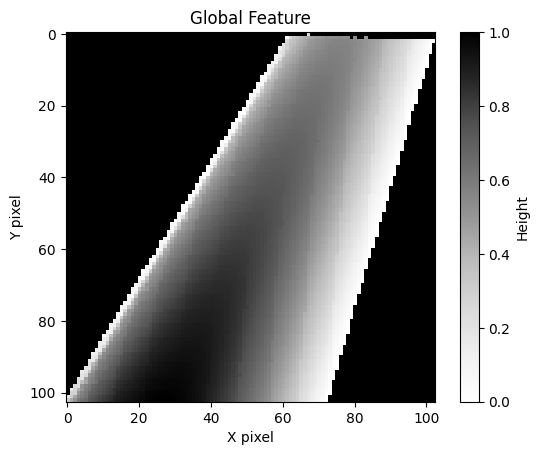

In [23]:
import numpy as np
import pandas as pd
file_path = 'postProcessing/boundaryCloud/1200/surface_p_res128.xy'
postProcessing_content = pd.read_csv(file_path, delimiter='\s+', skiprows=0, header=None, names=['x','y','z','p'])
upper = postProcessing_content[(postProcessing_content['z'] >= 0.)]
x = upper['x']
y = upper['y']
z = upper['z']
normalized_x = (x - x.min()) / (x.max() - x.min())
normalized_y = y / y.max()
normalized_z = (z - z.min()) / (z.max() - z.min())
res = round(len(x) ** (1/3))
npOutput = np.ones((res,res))
npOutput[(normalized_x * (res-1)).astype(int), (normalized_y * (res-1)).astype(int)] = normalized_z
field = np.copy(npOutput)
field = np.flipud(field.transpose())

import matplotlib.pyplot as plt
plt.imshow(field, cmap='Greys', interpolation='nearest')
plt.colorbar(label='Height')
plt.title('Global Feature')
plt.xlabel('X pixel')
plt.ylabel('Y pixel')

## Surface pressure coeff

/tmp/ipykernel_6636/1596505296.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upper['Cp'] = (upper['p']-98858.97) / pv


Text(0, 0.5, 'Y pixel')

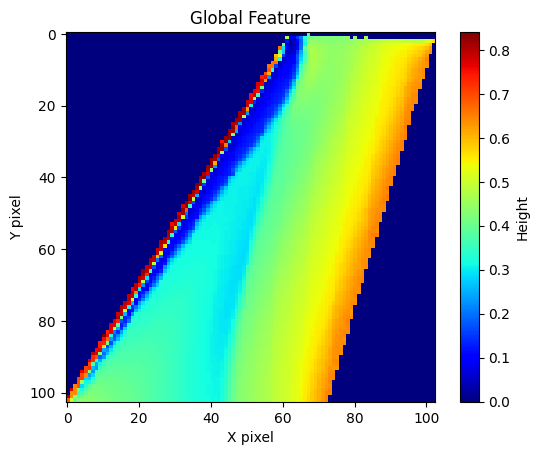

In [22]:
file_path = 'postProcessing/boundaryCloud/1200/surface_p_res128.xy'
postProcessing_content = pd.read_csv(file_path, delimiter='\s+', skiprows=0, header=None, names=['x','y','z','p'])
upper = postProcessing_content[(postProcessing_content['z'] >= 0.)]

rho = 1.184
v = 292.67
pv = 0.5 * rho * (v**2)
upper['Cp'] = (upper['p']-98858.97) / pv
def normalize(boundary_content):
    L = boundary_content['x'].max() - boundary_content['x'].min()
    lead = boundary_content['x'].min()
    boundary_content['X/L'] = (boundary_content['x'] - lead) / L
    return boundary_content
x = upper['x']
y = upper['y']
cp = upper['Cp']

normalized_x = (x - x.min()) / (x.max() - x.min())
normalized_y = y / y.max()
normalized_Cp = (cp - cp.min()) / (cp.max() - cp.min())
res = round(len(x) ** (1/3))
npOutput = np.zeros((res,res))
npOutput[(normalized_x * (res-1)).astype(int), (normalized_y * (res-1)).astype(int)] = normalized_Cp
field = np.copy(npOutput)
field = np.flipud(field.transpose())

import matplotlib.pyplot as plt
plt.imshow(field, cmap='jet', interpolation='nearest')
plt.colorbar(label='Height')
plt.title('Global Feature')
plt.xlabel('X pixel')
plt.ylabel('Y pixel')

## Section plot

/home/pggo/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='x', ylabel='z'>

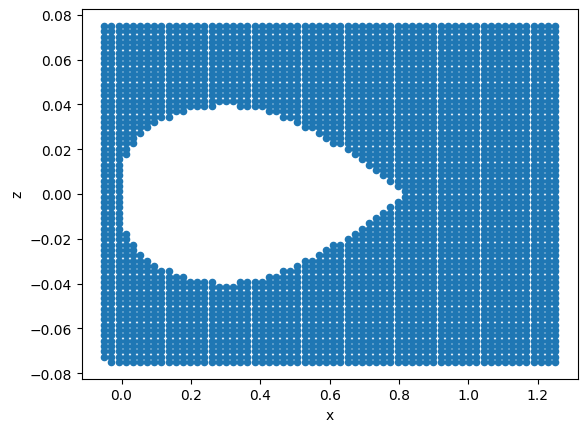

In [10]:
# Section
import pandas as pd
import numpy as np
# file_path = 'postProcessing/boundaryCloud/1200/surface_p.xy'
# boundary_content = pd.read_csv(file_path, delimiter='\s+', skiprows=1, header=None, names=['x','y','z','p']).round(5)
file_path = 'postProcessing/internalCloud/1200/AIP_p_U.xy'
boundary_content = pd.read_csv(file_path, delimiter='\s+', skiprows=1, header=None, names=['x','y','z','p','u','v','w']).round(5)

rho = 1.184
v = 292.67
pv = 0.5 * rho * (v**2)
boundary_content['Cp'] = (boundary_content['p']-98858.97) / pv
def normalize(boundary_content):
    L = boundary_content['x'].max() - boundary_content['x'].min()
    lead = boundary_content['x'].min()
    boundary_content['X/L'] = (boundary_content['x'] - lead) / L
    return boundary_content
boundary_content.plot(kind='scatter',x='x',y='z')

# Residual plot

In [15]:
import re
log_path = 'log/hisa.log'
with open(log_path,'r') as file:
    log_content = file.read()
GMRES_pattern = r"GMRES iteration: 0\s+Residual:\s+([0-9.]+)"
GMRES_matches = re.findall(GMRES_pattern, log_content)
omega_pattern = r"Solving for omega, Initial residual = ([0-9.eE+-]+)"
omega_matches = re.findall(omega_pattern, log_content)
k_pattern = r"smoothSolver:  Solving for k, Initial residual = ([0-9.eE+-]+)"
k_matches = re.findall(k_pattern, log_content)

if GMRES_matches:
    GMRES_residual = [float(value) for value in GMRES_matches]
else:
    print("No GMRES matches found")

if omega_matches:
    omega_residual = [float(value) for value in omega_matches]
else:
    print("No matches found for Omega Initial residual")

if k_matches:
    k_residual = [float(value) for value in k_matches]
else:
    print("No matches found for K Initial residual")

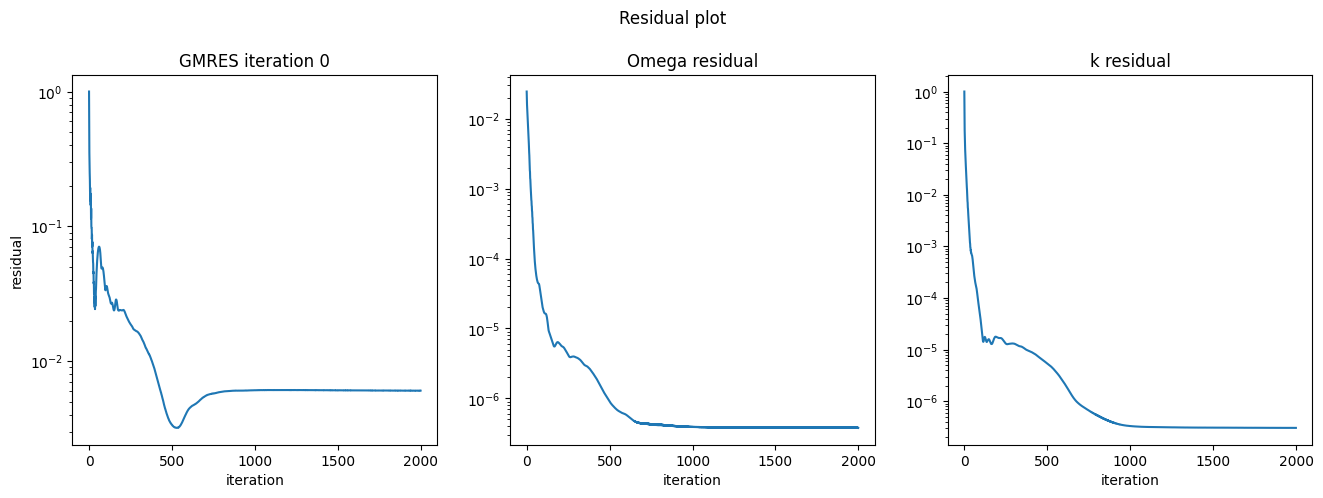

In [16]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3, figsize=(16,5))
axes[0].semilogy(GMRES_residual)
axes[0].set_title('GMRES iteration 0')
axes[0].set_ylabel('residual')
axes[0].set_xlabel('iteration')
axes[1].semilogy(omega_residual)
axes[1].set_title('Omega residual')
axes[1].set_xlabel('iteration')
axes[2].semilogy(k_residual)
axes[2].set_title('k residual')
axes[2].set_xlabel('iteration')

fig.suptitle('Residual plot')
plt.subplots_adjust(top=0.85)